# data analysis for model comparison study
### August George, OHSU, 2023


#### Data organization
The data for each pocoMC run is stored in a folder with a unique identifier. 

For the analysis, use `samples.csv`, `log_evidence.csv`, and `log_likelihood.csv` contained in the folder.

`samples.csv` contains the parameter values (columns) for each sample (rows) during the final sequential Monte Carlo sampling stage. 

`log_evidence.csv` contains the estimated log evidence values for each sampling stage (rows). Use the last value which corresponds to the final sampling stage. 

`log_likelihood.csv` contains the log likelihood values for each sample (rows) during the final sampling stage. 

#### Loading the data

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import yaml
import math


# Define the base directory containing all data subdirectories
base_directory = "/Users/georgeau/Desktop/extended_model_runs"

# Define the list of model names and replica IDs
model_names = [f"cycle{i}" for i in range(1, 5)]
replica_ids = [6, 7, 8, 9]

# Define a function to load data from a specific folder
def load_data(folder):
    samples = np.loadtxt(os.path.join(folder, "samples.csv"), delimiter=',')
    log_likelihood = np.loadtxt(os.path.join(folder, "log_likelihood.csv"), delimiter=',')
    log_evidence = np.loadtxt(os.path.join(folder, "log_evidence.csv"), delimiter=',')
    return samples, log_likelihood, log_evidence

# Load data for all models and replicas
all_data = {}
parameter_info = {}
for model_name in model_names:
    
    model_folders = [folder for folder in glob.glob(os.path.join(base_directory, f"run_*{model_name}*")) if os.path.isdir(folder)]
    
    if model_folders:
        replicas_data = []
        
        for replica_id in replica_ids:
            replica_folders = [folder for folder in model_folders if f"_r{replica_id}_" in folder]

            if replica_folders:
                replica_folder = replica_folders[0]
                replica_data = load_data(replica_folder)
                replicas_data.append(replica_data)


                # Find the YAML file containing 'config' in its name
                yaml_files = glob.glob(os.path.join(replica_folder, "*config*.yaml"))
                if yaml_files:
                    yaml_file = yaml_files[0]
                # Read parameter information from the YAML file
                with open(yaml_file, 'r') as f:
                    yaml_data = yaml.safe_load(f)
                    params = yaml_data['bayesian_inference']['parameters']
                    
                    # Save parameter names, ranges, and nominal values
                    parameter_names = [param['name'] for param in params]
                    parameter_ranges = [tuple(param['bounds']) for param in params]
                    parameter_nominals = [param['nominal'] for param in params]
                
                parameter_info[model_name] = {
                    'names': parameter_names,
                    'ranges': parameter_ranges,
                    'nominals': parameter_nominals
                }
            else:
                print(f"Replica folder for model {model_name} and replica ID {replica_id} not found. Skipping.")
        
        all_data[model_name] = replicas_data
    else:
        print(f"Model folder for {model_name} not found. Skipping.")

# all_data[model_name][replica_id][0=samples, 1=log likelihood, 2=log evidence]
# parameter_info[model_name]['names', 'ranges', 'nominals']

#### individual model comparison (replicas)
For each model replica, plot the 1D marginal distributions, 2D corner plots, log liklihood distributions, and log evidence

Figure saved as output_figures/cycle1_sampling_distributions.png
Figure saved as output_figures/cycle1_corner_plot.png
Figure saved as output_figures/cycle1_likelihoods.png
Figure saved as output_figures/cycle1_log_evidence.png
Figure saved as output_figures/cycle2_sampling_distributions.png
Figure saved as output_figures/cycle2_corner_plot.png
Figure saved as output_figures/cycle2_likelihoods.png
Figure saved as output_figures/cycle2_log_evidence.png
Figure saved as output_figures/cycle3_sampling_distributions.png
Figure saved as output_figures/cycle3_corner_plot.png
Figure saved as output_figures/cycle3_likelihoods.png
Figure saved as output_figures/cycle3_log_evidence.png
Figure saved as output_figures/cycle4_sampling_distributions.png
Figure saved as output_figures/cycle4_corner_plot.png
Figure saved as output_figures/cycle4_likelihoods.png
Figure saved as output_figures/cycle4_log_evidence.png


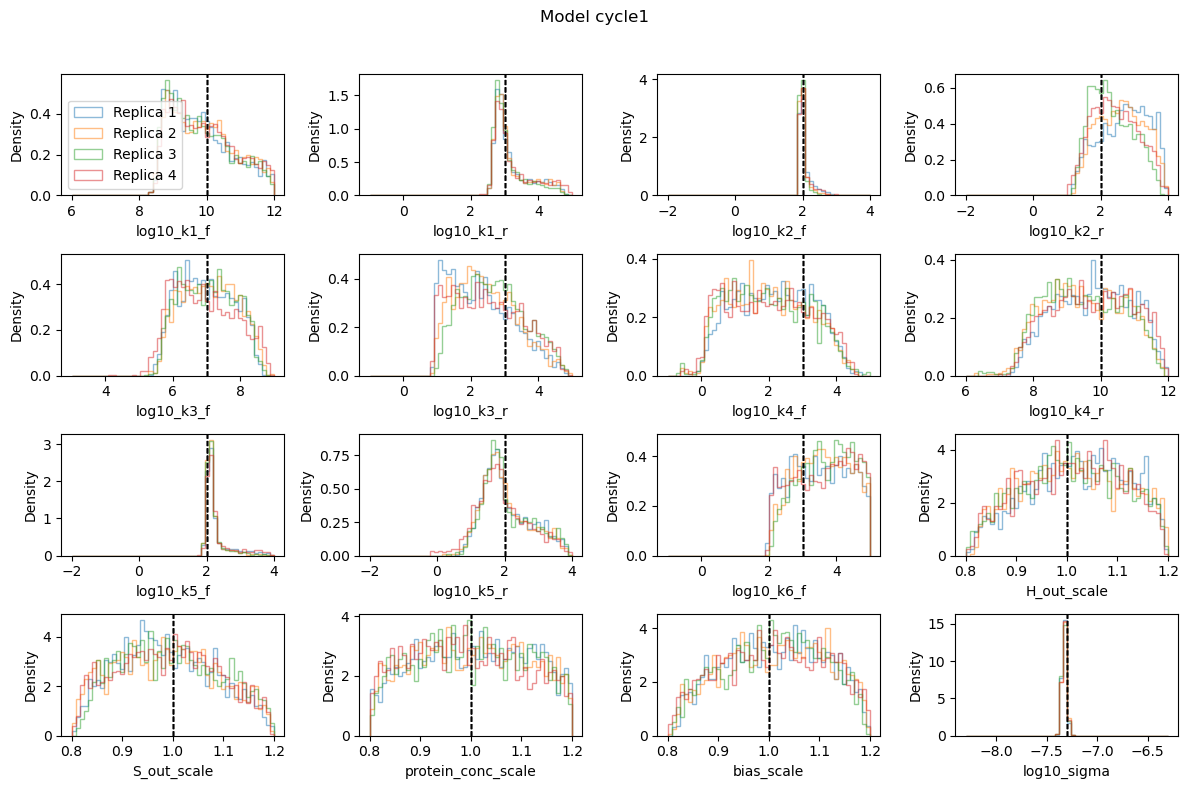

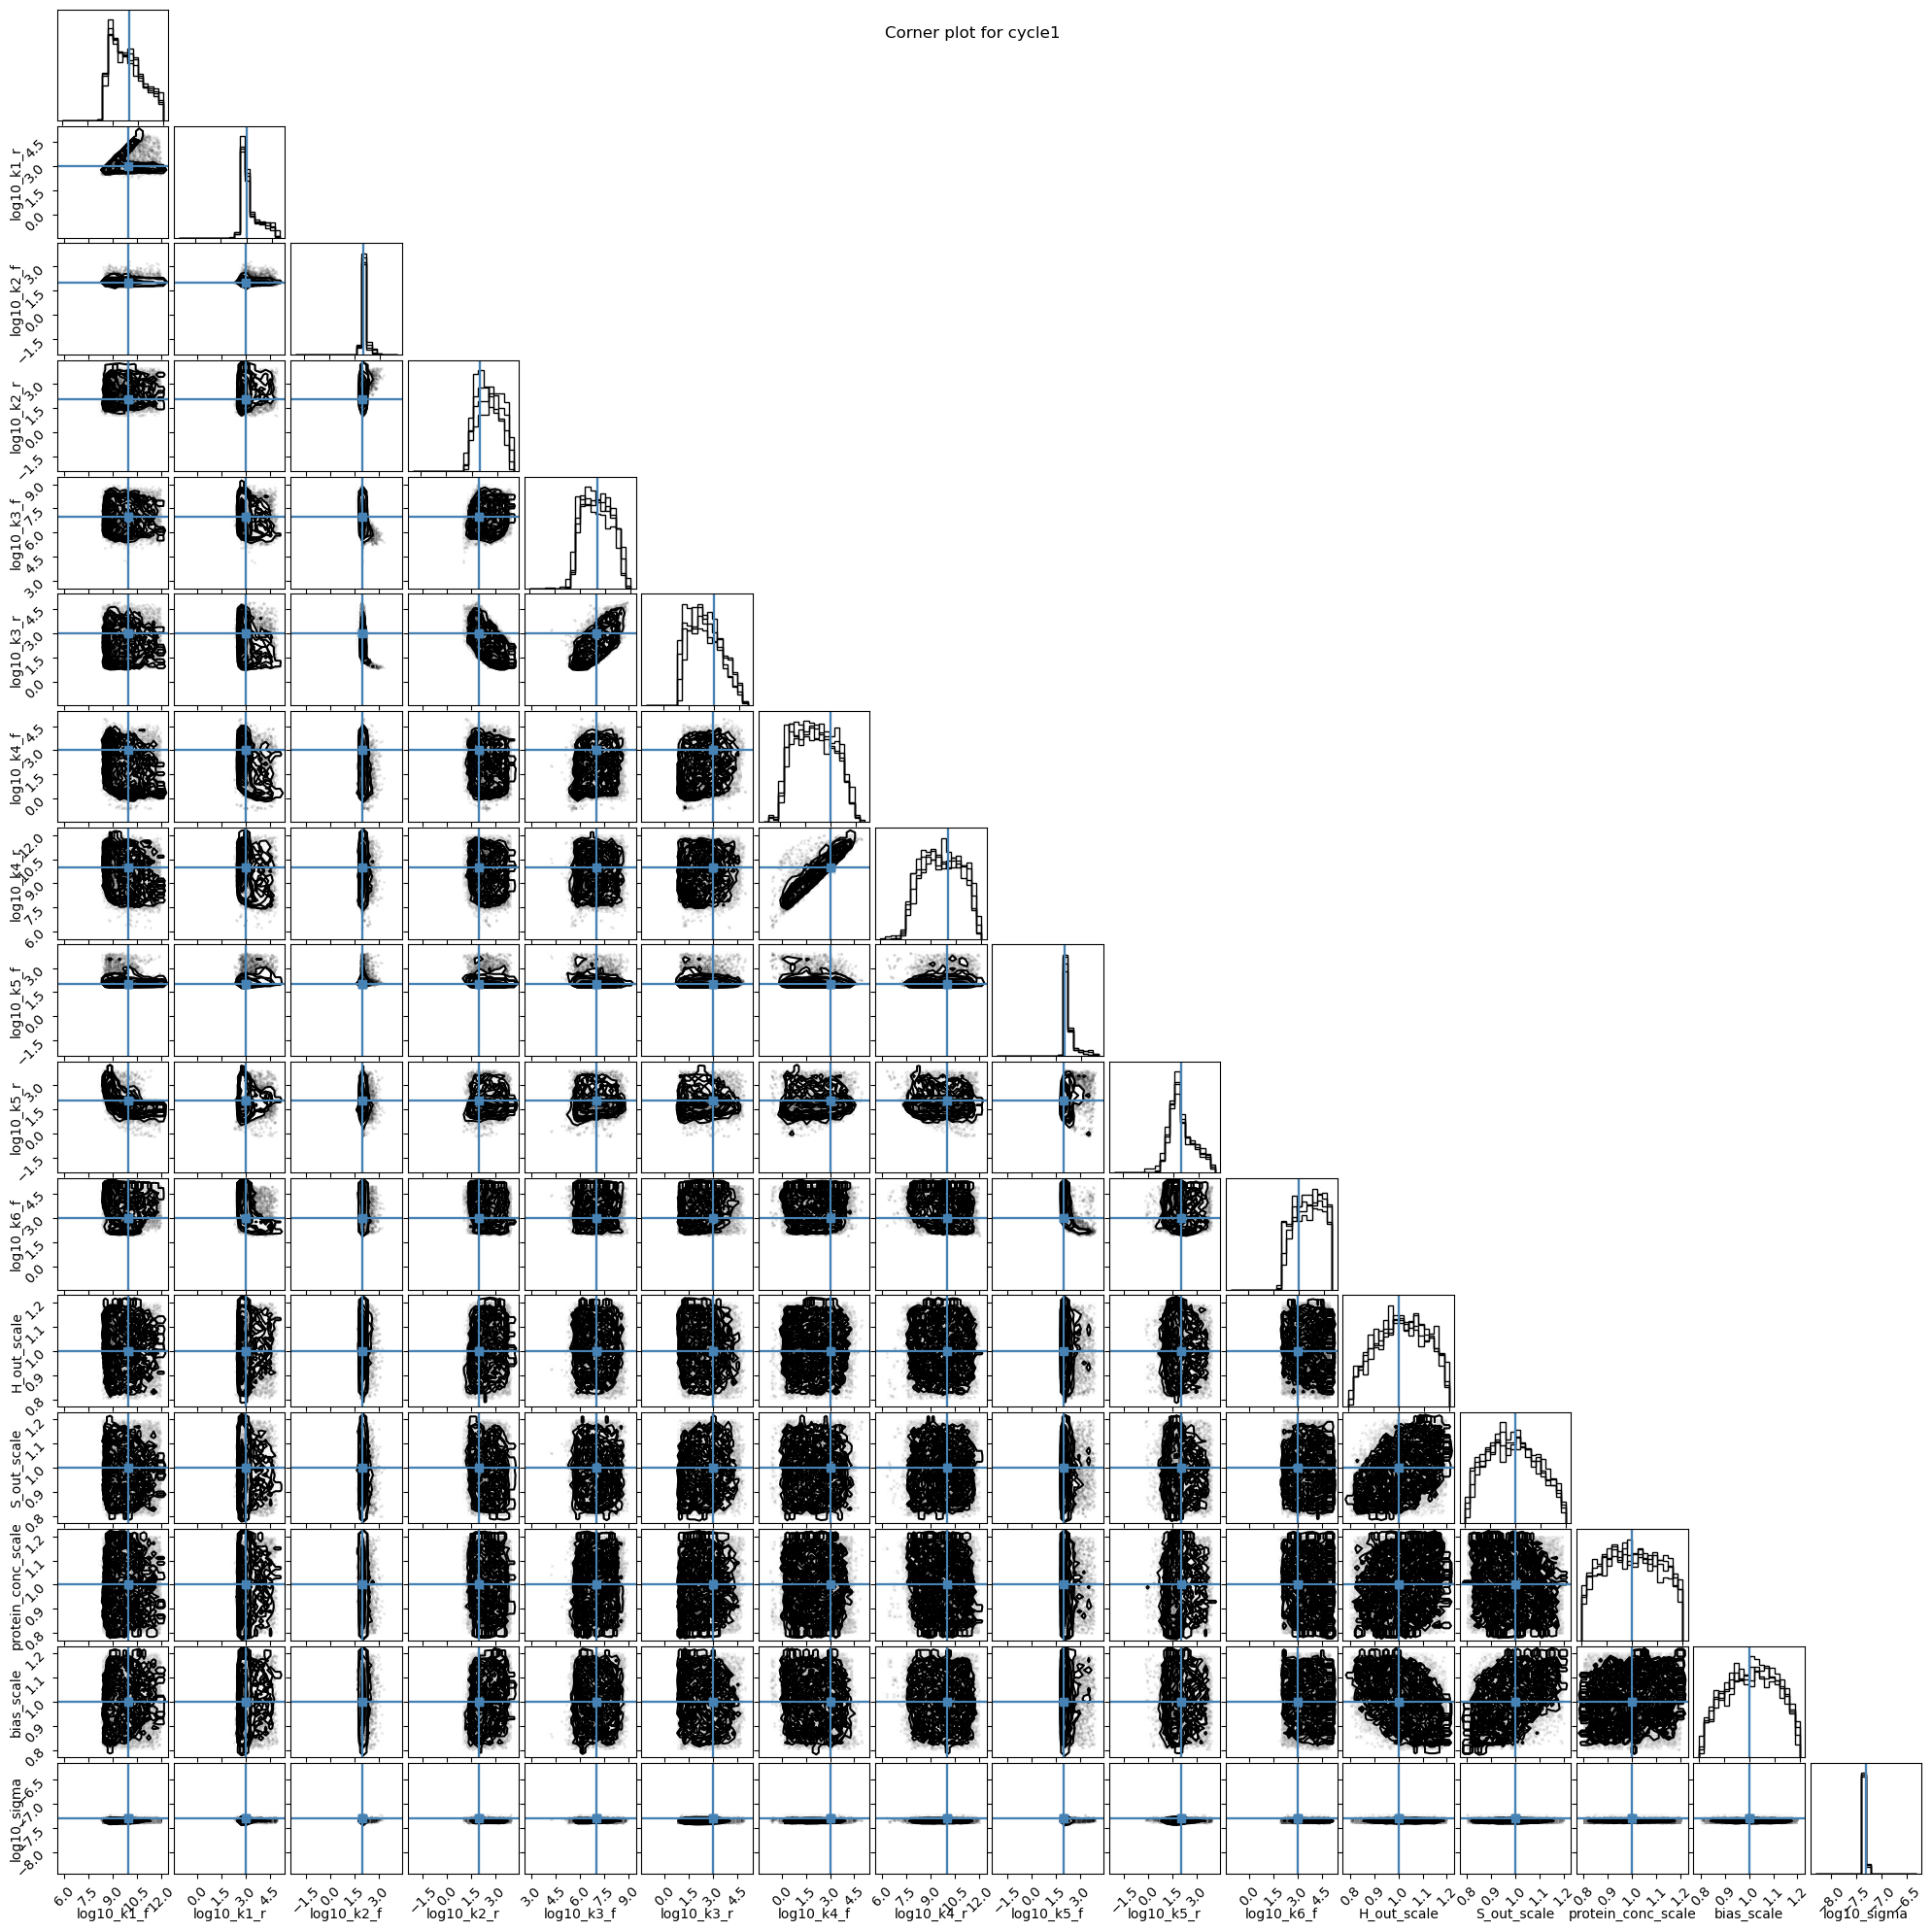

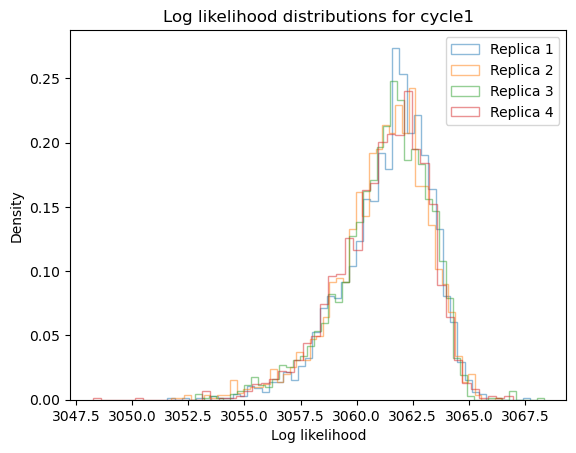

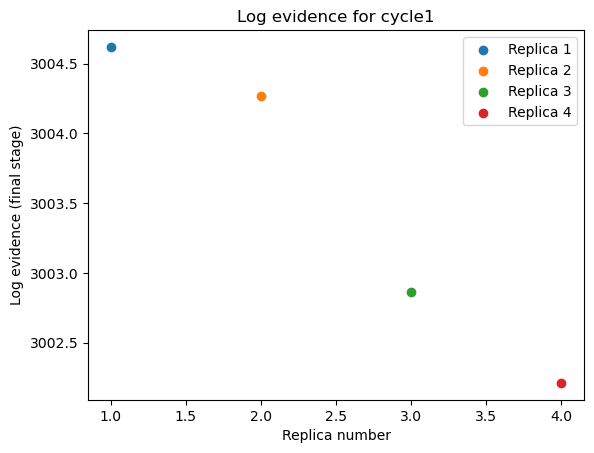

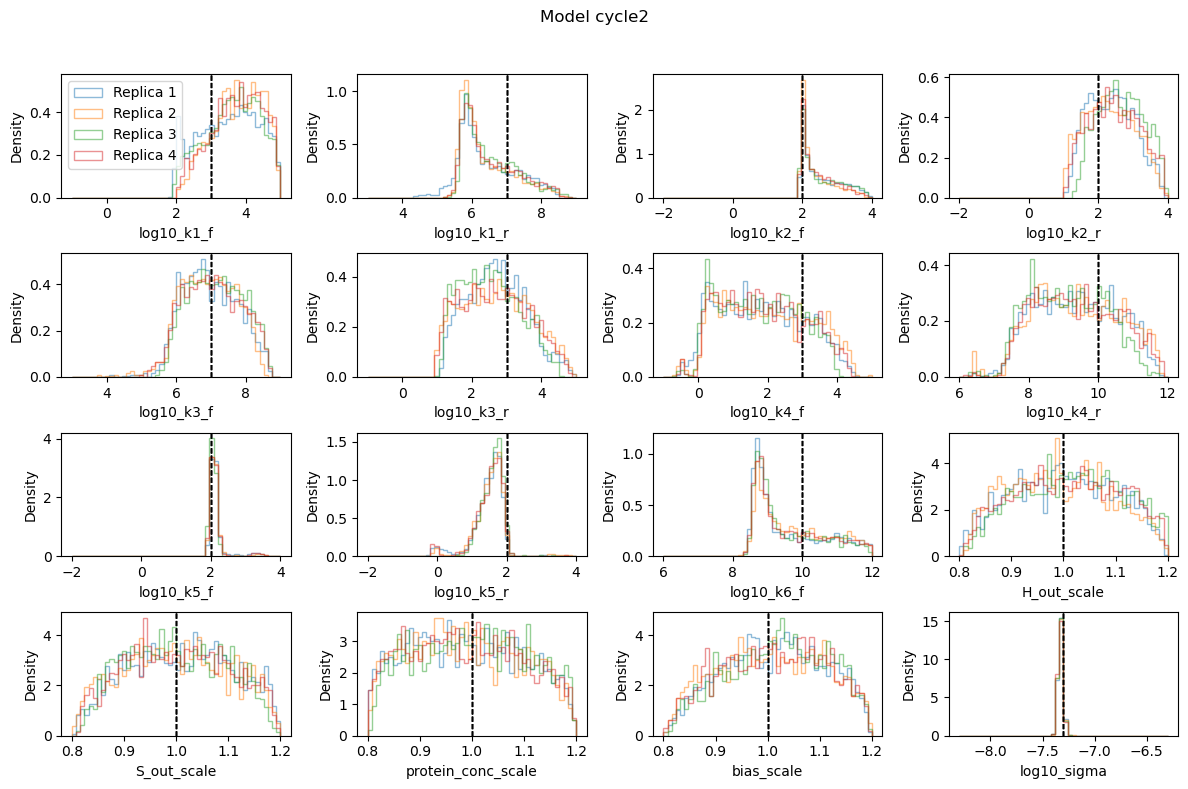

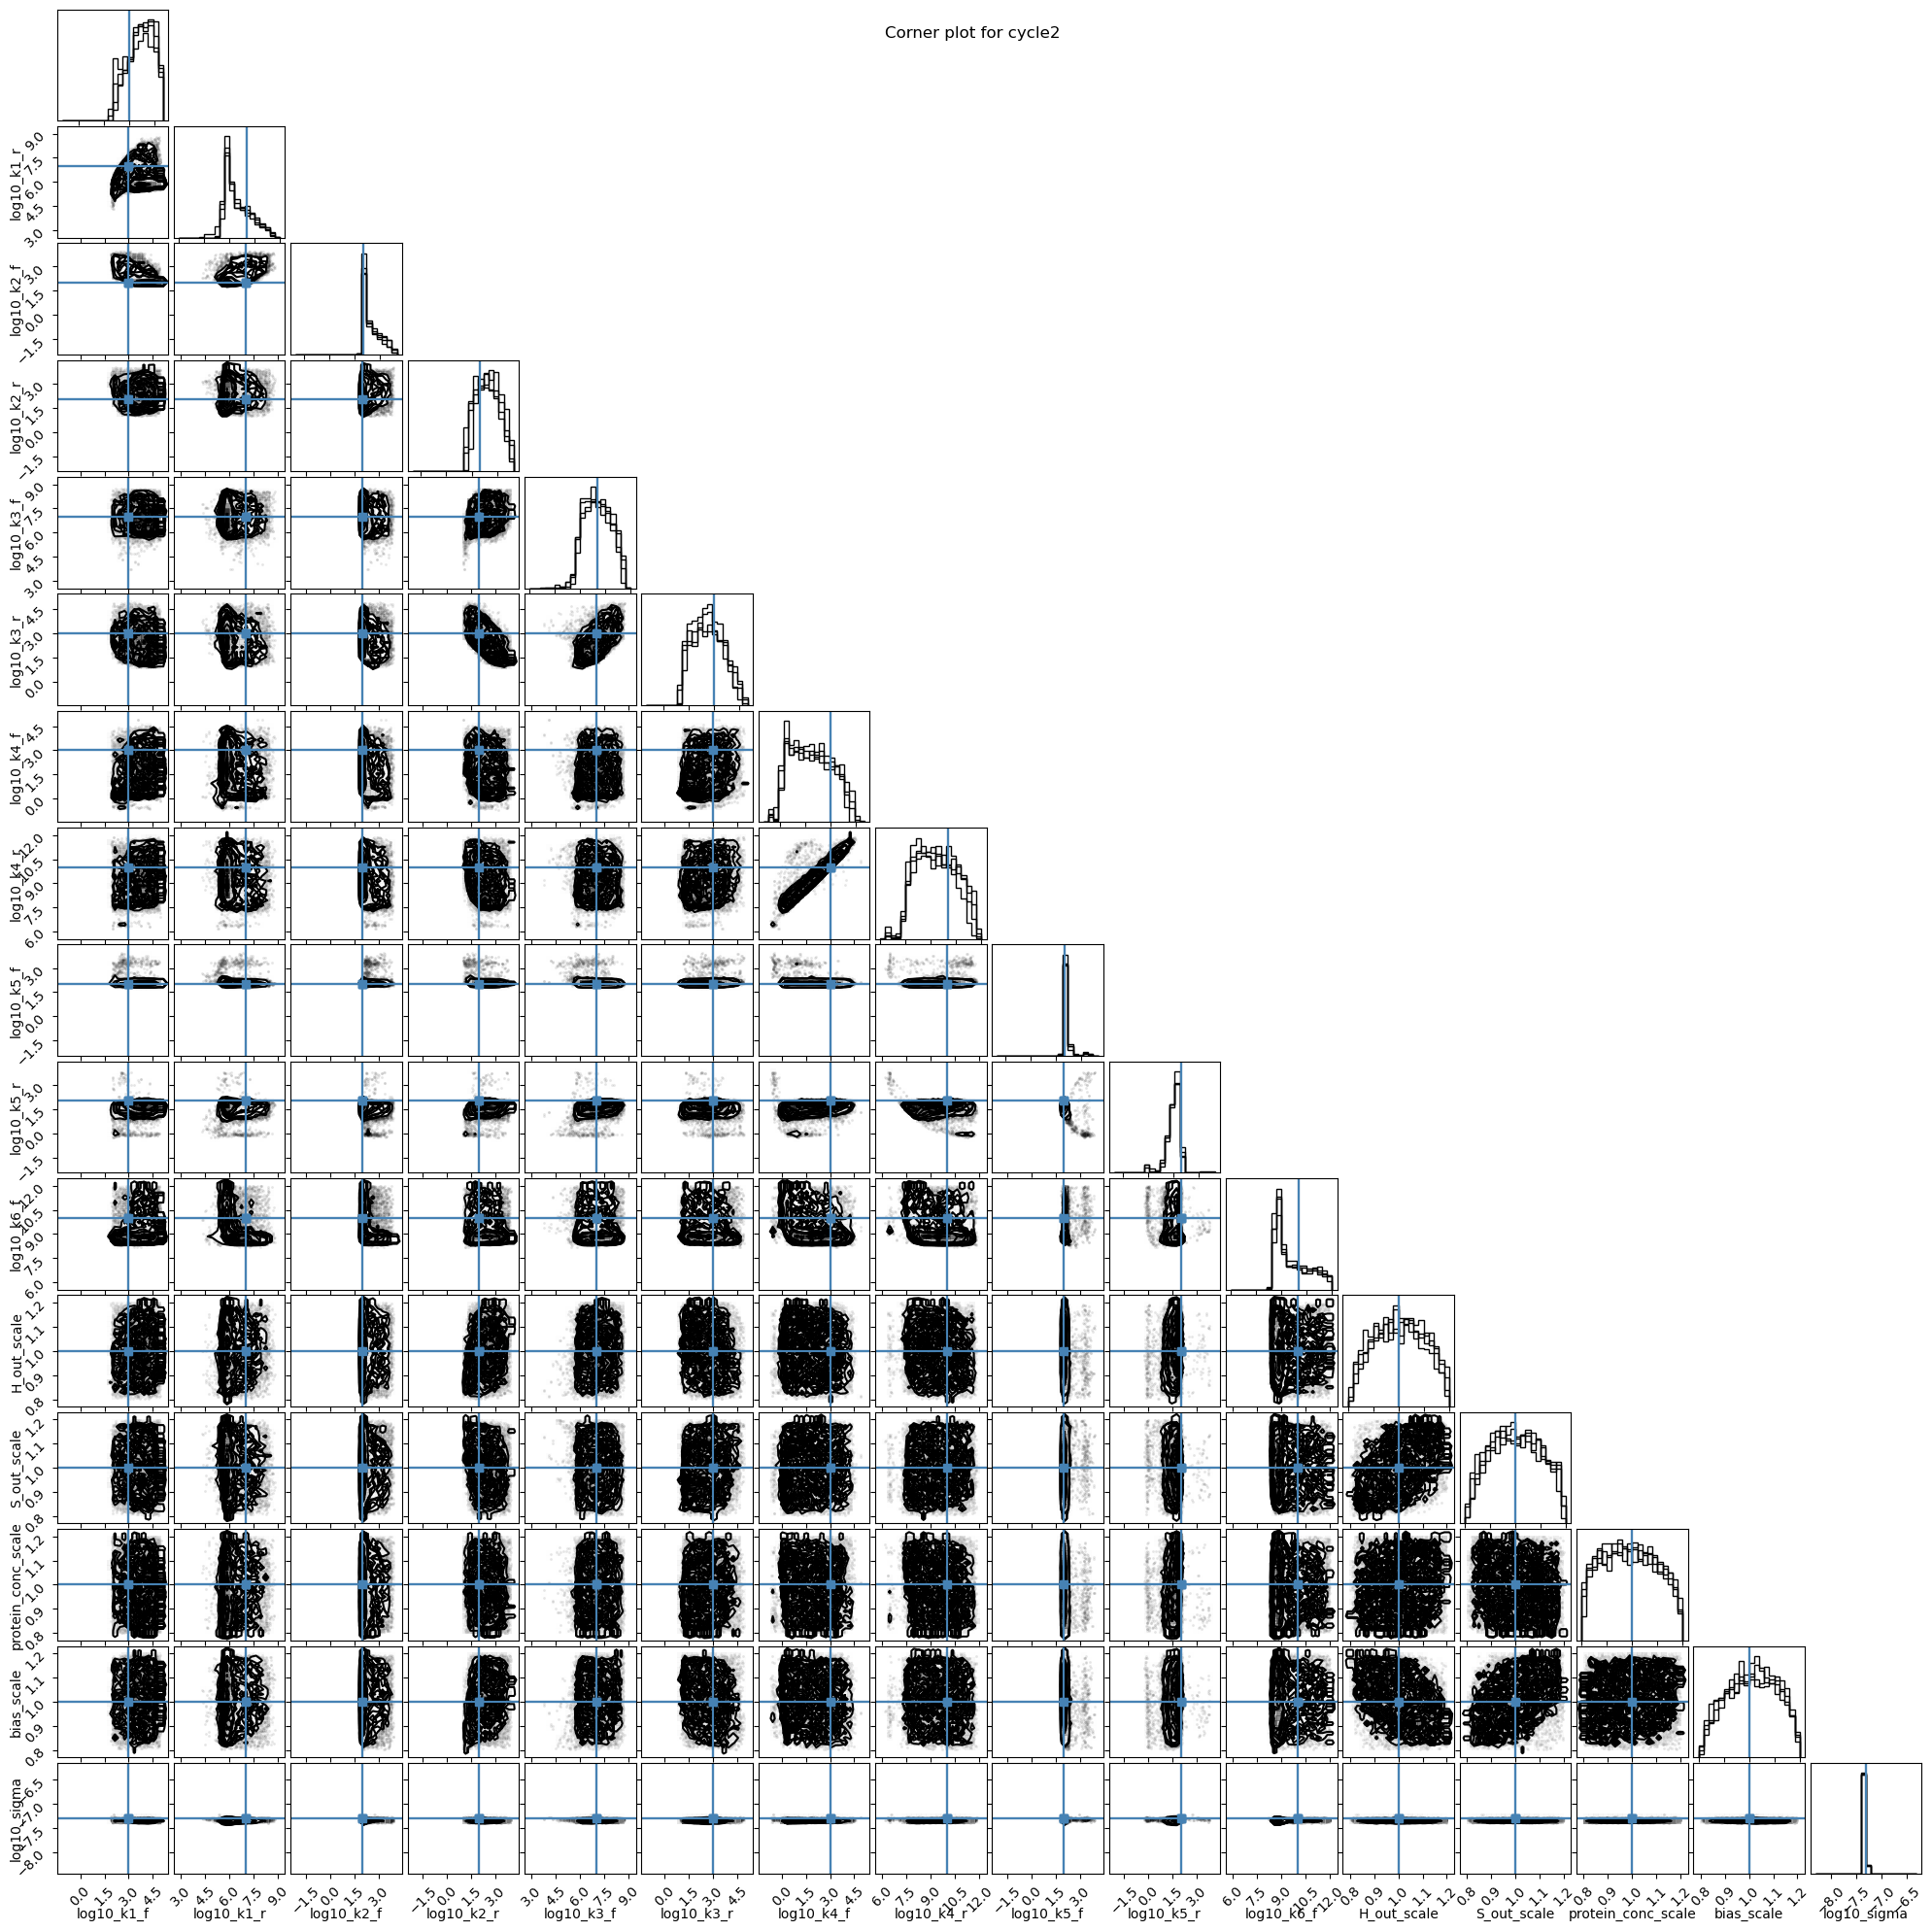

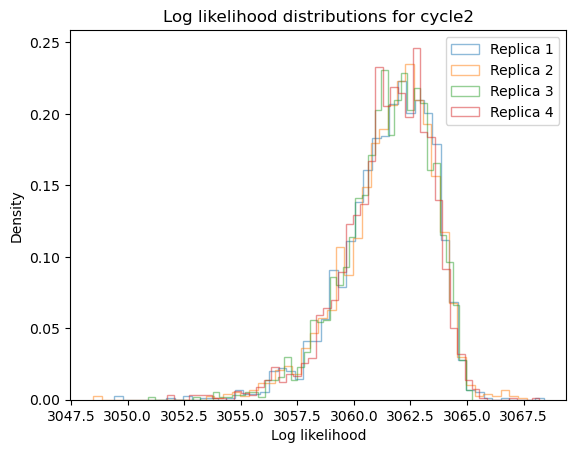

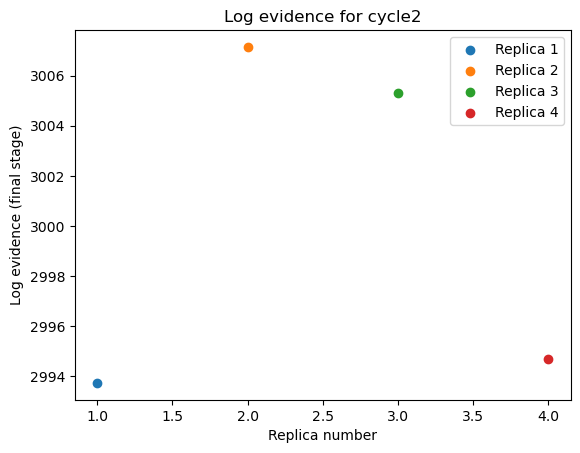

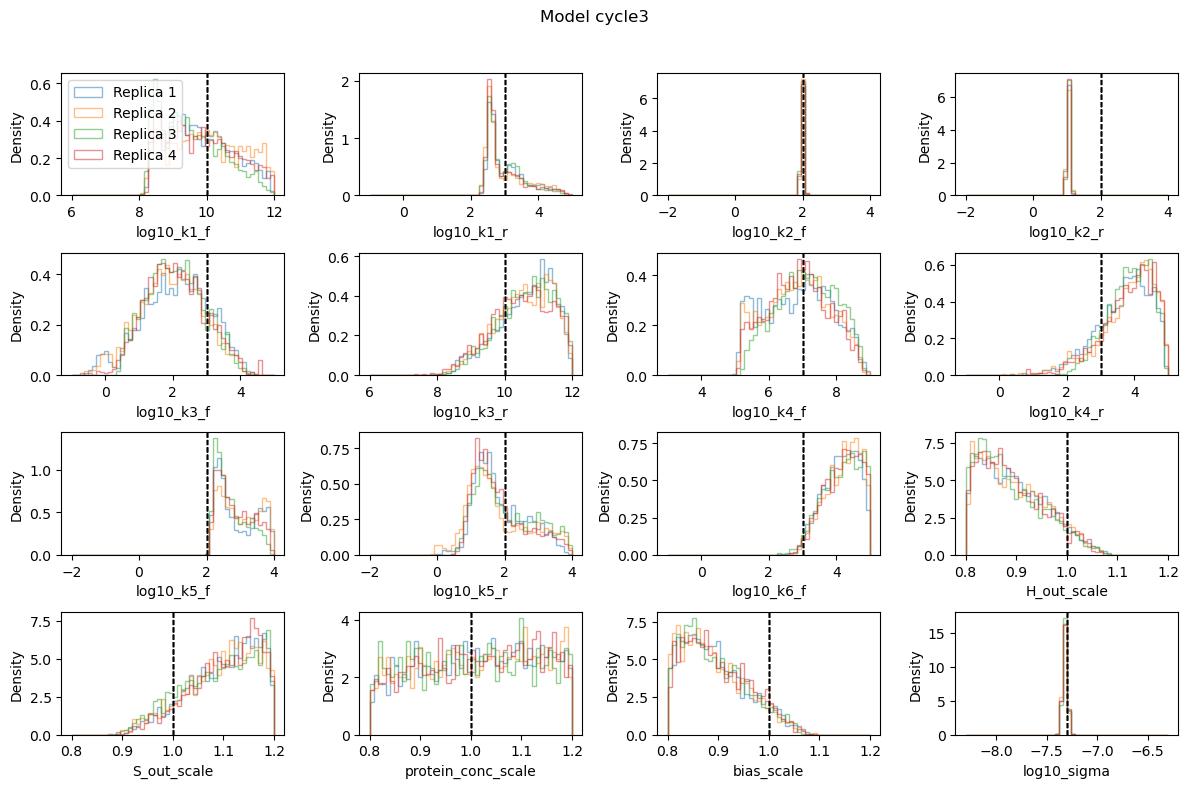

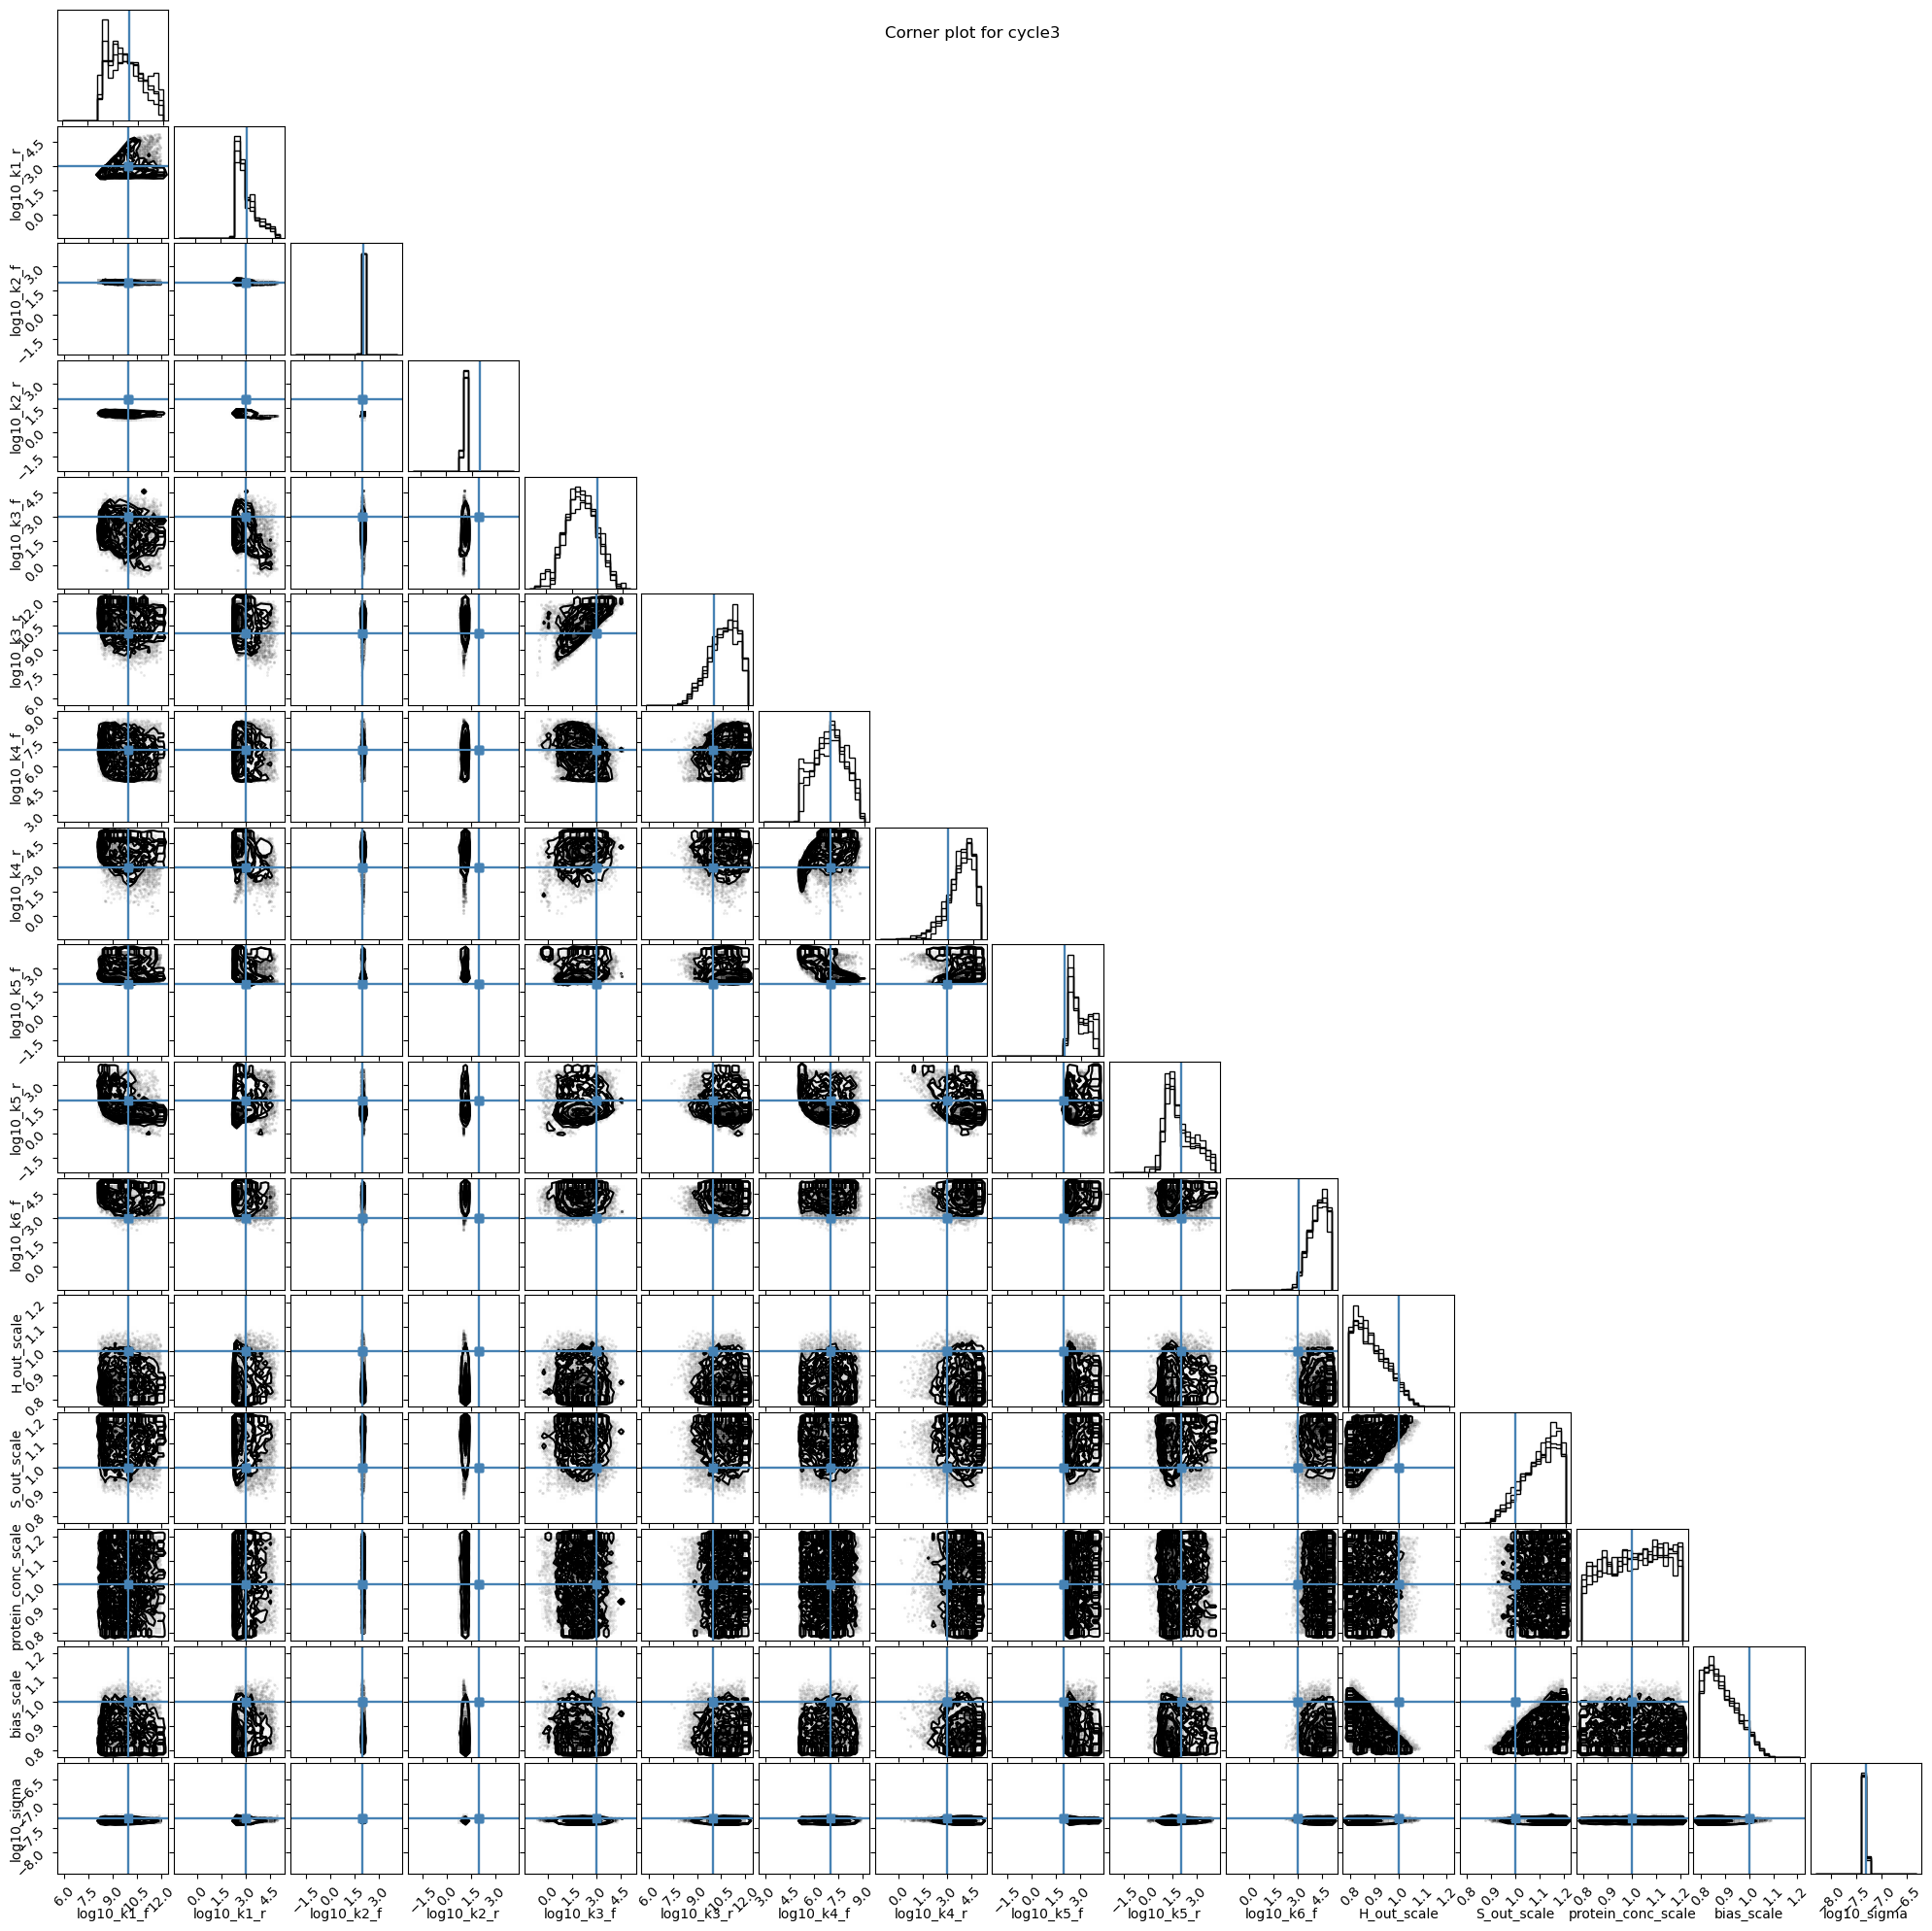

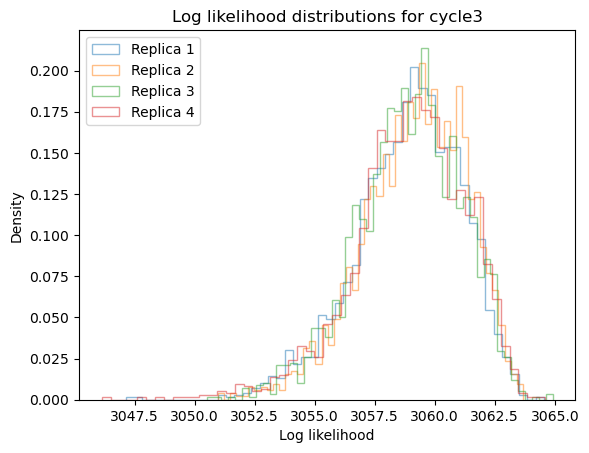

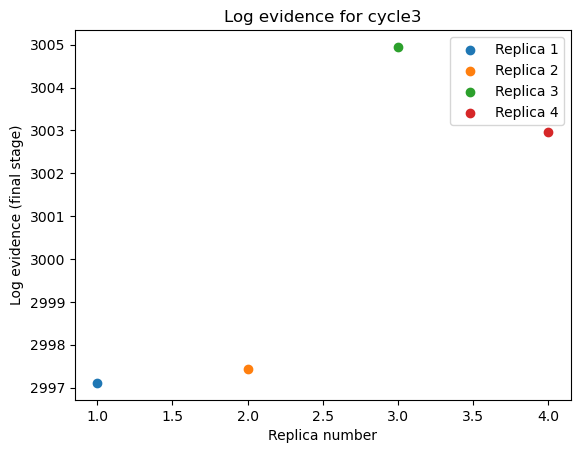

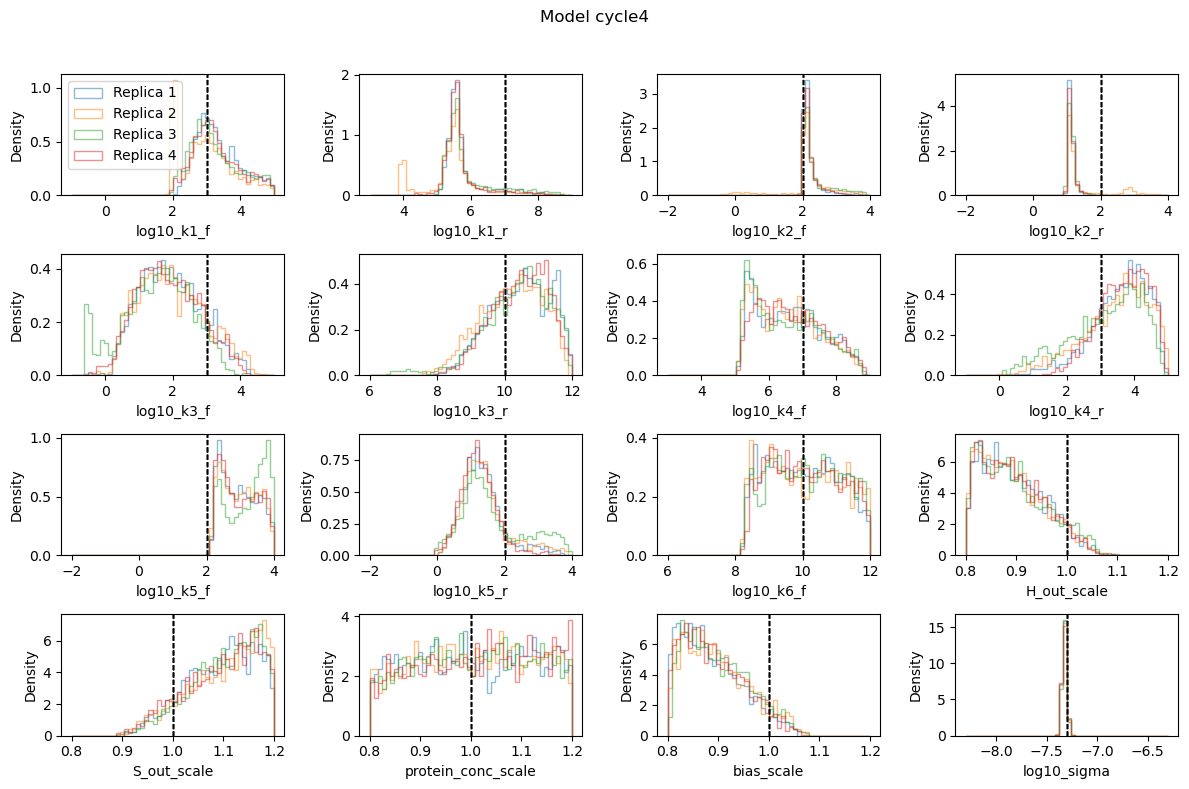

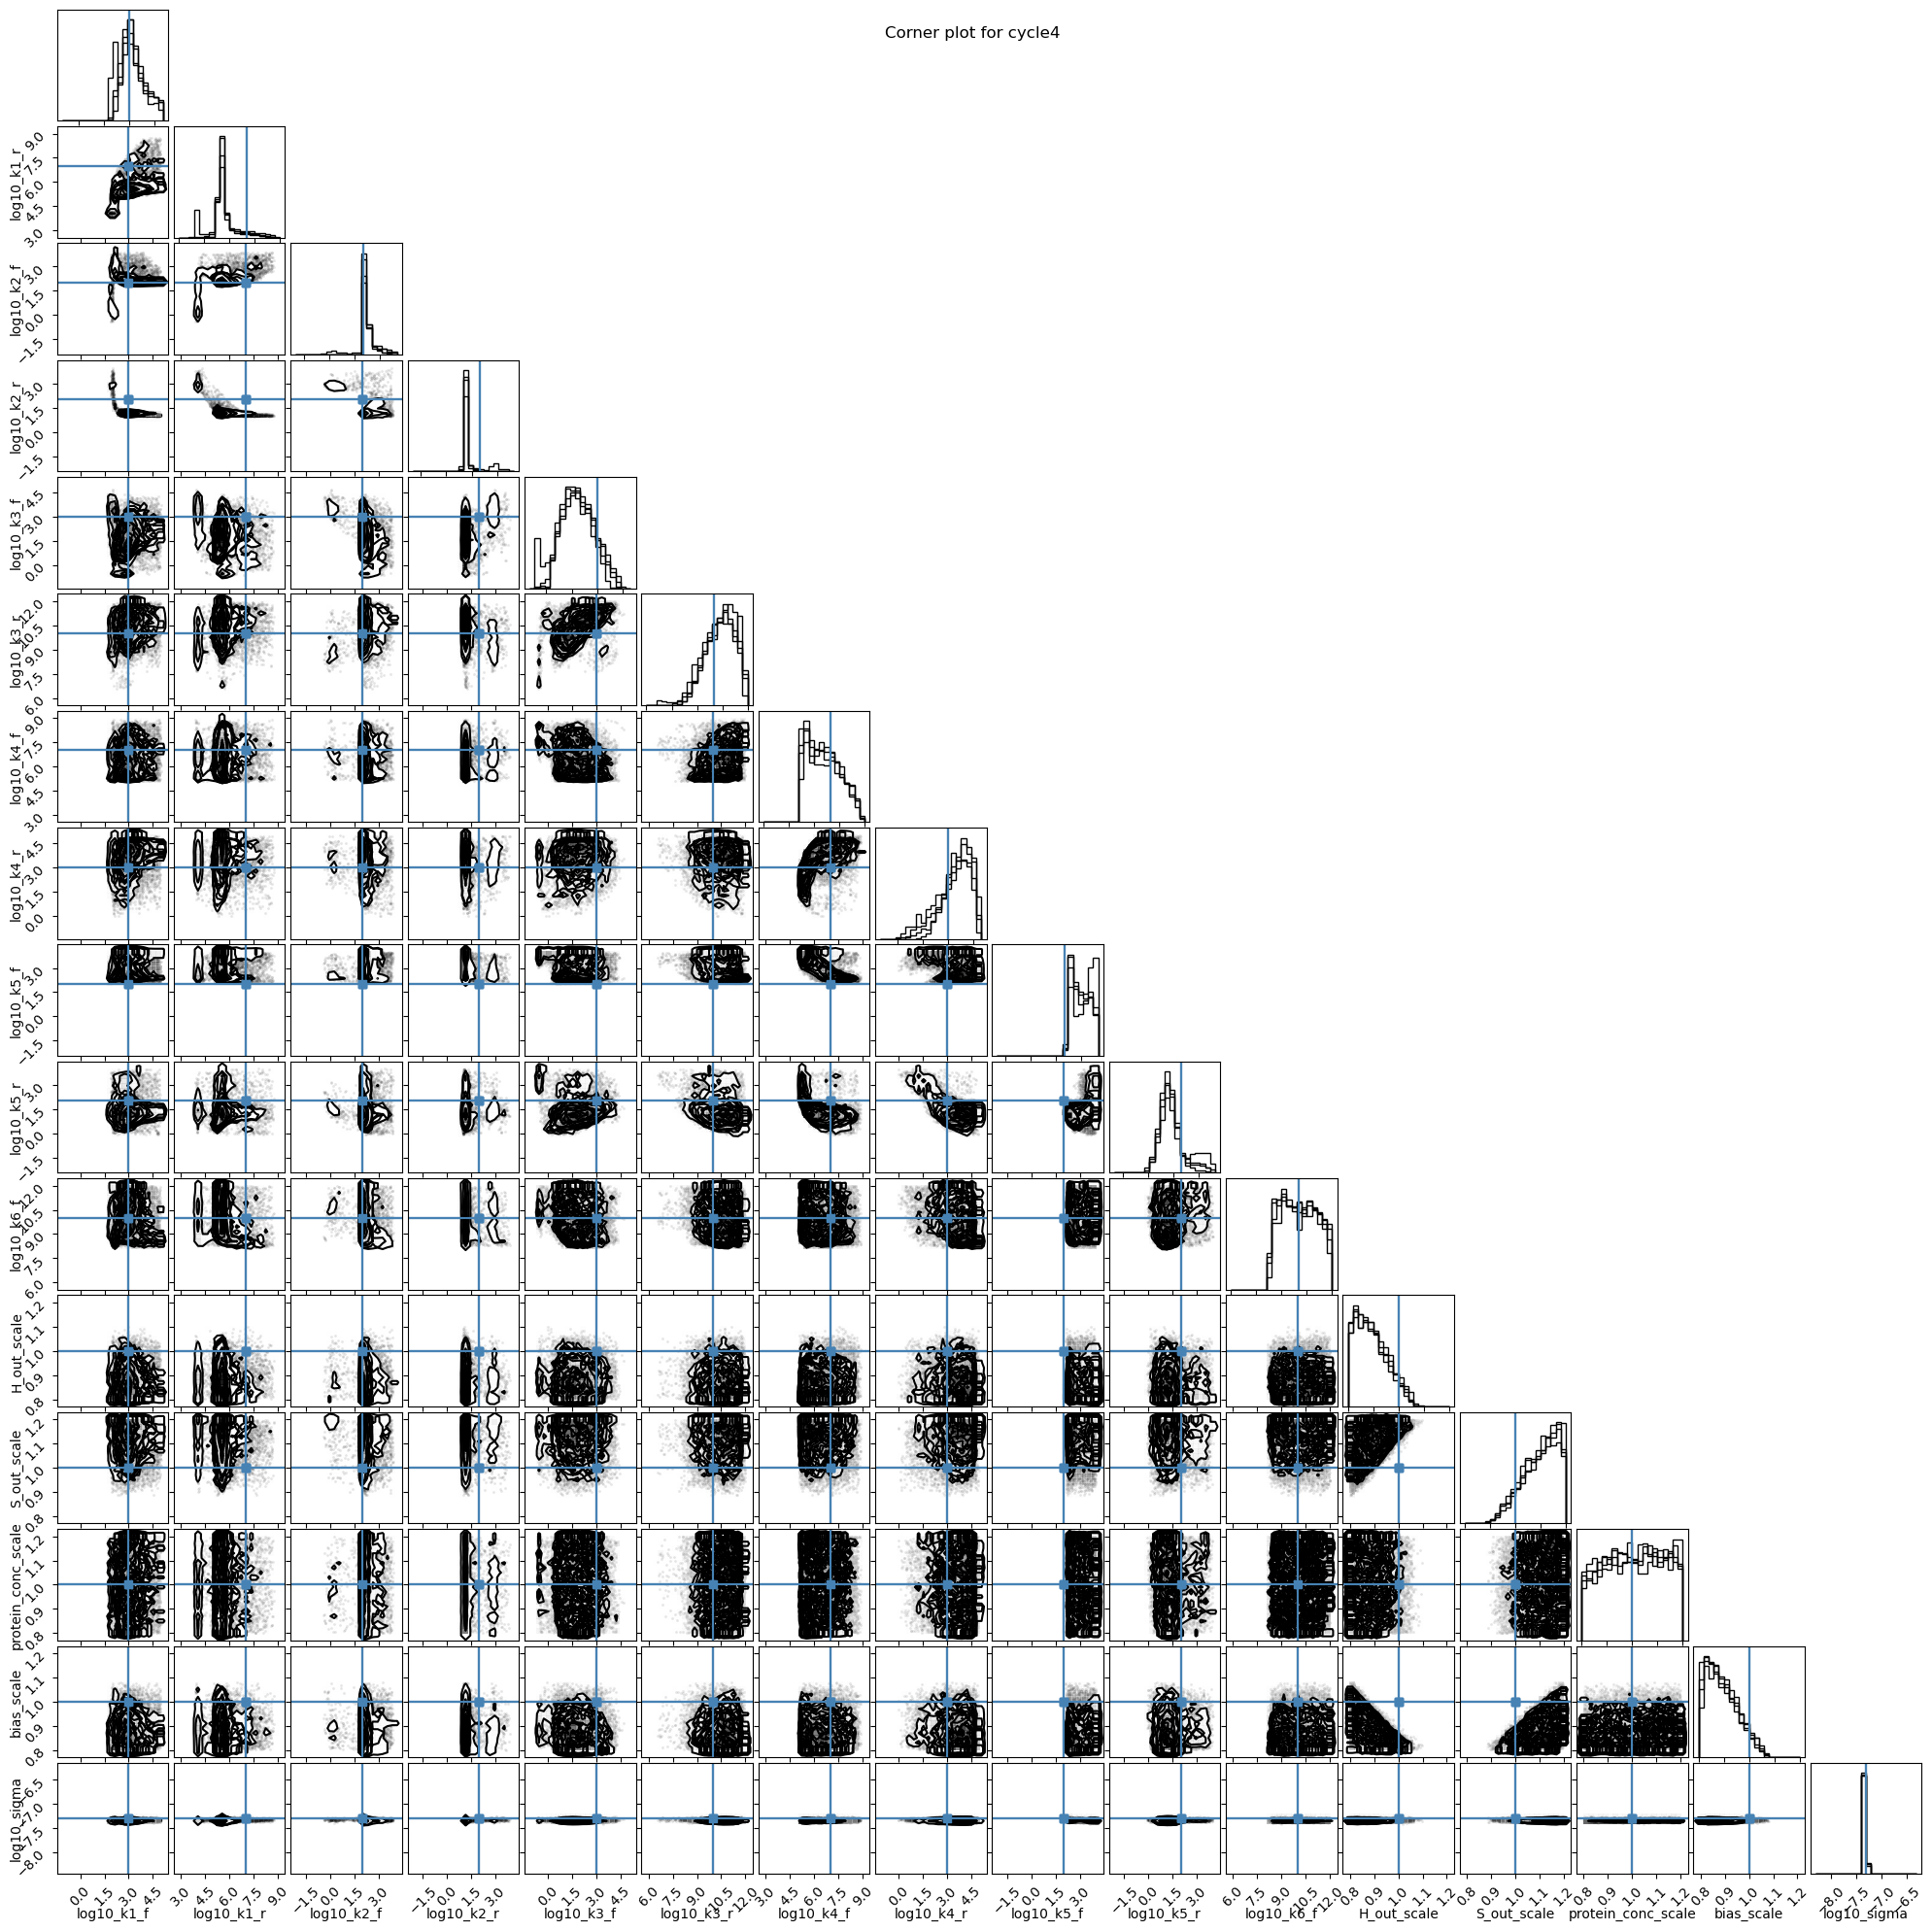

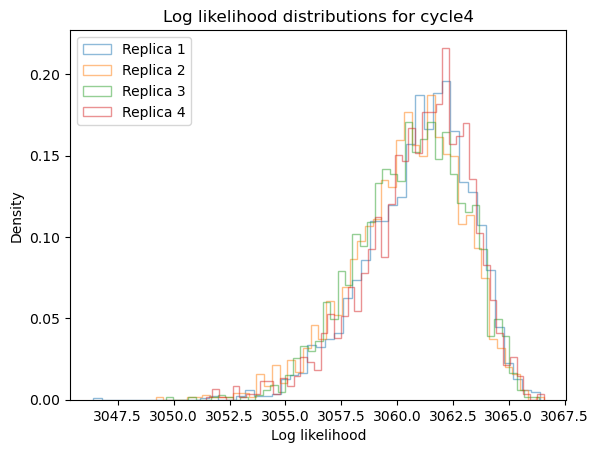

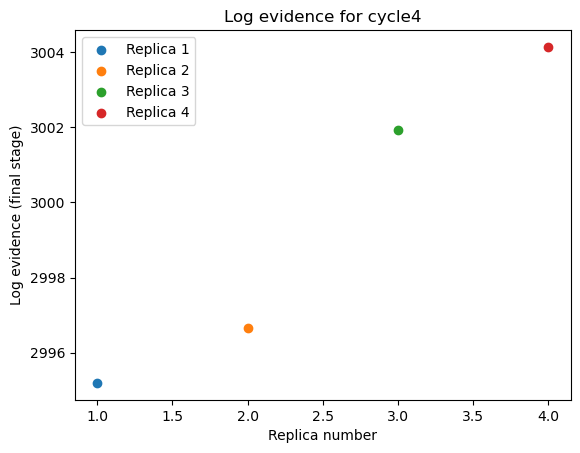

In [58]:
import math
import corner


output_directory = "output_figures"  # Set the output directory path

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def save_figure(fig, file_name, output_directory):
    file_path = os.path.join(output_directory, file_name)
    fig.savefig(file_path)
    print(f"Figure saved as {file_path}")


def plot_sampling_distributions(model_name, all_data, parameter_info):
    plt.style.use('default')
    num_bins = 50

    num_replicas = len(all_data[model_name])
    num_parameters = all_data[model_name][0][0].shape[1]

    parameter_names = parameter_info[model_name]['names']
    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_nominals = parameter_info[model_name]['nominals']

    num_cols = math.ceil(math.sqrt(num_parameters))
    num_rows = math.ceil(num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 2 * num_rows))
    axs = axs.flatten()

    for replica_idx, replica_data in enumerate(all_data[model_name]):
        samples = replica_data[0]

        for param_idx in range(num_parameters):
            axs[param_idx].hist(samples[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1}", range=parameter_ranges[param_idx])
            axs[param_idx].axvline(parameter_nominals[param_idx], linestyle='--', color='k', linewidth=1)
            axs[param_idx].set_xlabel(parameter_names[param_idx])
            axs[param_idx].set_ylabel('Density')

    axs[0].legend()
    fig.suptitle(f'Model {model_name}')

    for param_idx in range(num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #plt.show()
    return fig


def plot_corner_plot(model_name, all_data, parameter_info):
    parameter_ranges = parameter_info[model_name]['ranges']
    parameter_names = parameter_info[model_name]['names']
    parameter_nominals = parameter_info[model_name]['nominals']
    fig = plt.figure(figsize=(20,20))
    # Generate corner plot
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        samples = replica_data[0]
        corner.corner(samples, labels=parameter_names, range=parameter_ranges, fig=fig, truths=parameter_nominals,plot_contours=True, quiet=True)
    plt.suptitle(f'Corner plot for {model_name}')
    #plt.show()
    return fig

def plot_likelihoods(model_name, all_data):
    # Plot likelihoods
    fig, ax = plt.subplots()
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        ax.hist(replica_data[1], bins=num_bins, alpha=0.5, density=True, histtype='step', label=f"Replica {replica_idx + 1}")
    ax.set_xlabel('Log likelihood')
    ax.set_ylabel('Density')
    ax.legend()
    plt.title(f'Log likelihood distributions for {model_name}')
    #plt.show()
    return fig

def plot_log_evidence(model_name, all_data):
    # Plot log evidence
    fig, ax = plt.subplots()
    for replica_idx, replica_data in enumerate(all_data[model_name]):
        ax.scatter(replica_idx+1, replica_data[2][-1], label=f"Replica {replica_idx + 1}")
    ax.set_xlabel('Replica number')
    ax.set_ylabel('Log evidence (final stage)')
    ax.legend()
    plt.title(f'Log evidence for {model_name}')
    #plt.show()
    return fig


# Call the functions within the main loop
for model_name in model_names:
    fig = plot_sampling_distributions(model_name, all_data, parameter_info);
    save_figure(fig, f"{model_name}_sampling_distributions.png", output_directory);

    fig = plot_corner_plot(model_name, all_data, parameter_info);
    save_figure(fig, f"{model_name}_corner_plot.png", output_directory);

    fig = plot_likelihoods(model_name, all_data);
    save_figure(fig, f"{model_name}_likelihoods.png", output_directory);

    fig = plot_log_evidence(model_name, all_data);
    save_figure(fig, f"{model_name}_log_evidence.png", output_directory);


#### comparing models

Figure saved as output_figures/model_comparison_sampling_distributions.png
Figure saved as output_figures/model_comparison_log_likelihood_distributions.png
Figure saved as output_figures/model_comparison_log_evidence_distributions.png
{'cycle2': [53420.23189502189, 0.08011329446975976, 0.5006948297155036, 20788.82994555994, 37453.39789469977, 0.05616814057130242, 0.3510415813620087, 14575.232867696766, 9216.588858976229, 0.013821941071256876, 0.08638484382417934, 3586.69537122047, 4805.621639125565, 0.007206898357200741, 0.04504192181358421, 1870.1388499175373], 'cycle3': [1825.0831219017862, 1318.757359631551, 0.7200655569911887, 5.2771189710387825, 1279.5819473381646, 924.5924692709333, 0.5048443419200651, 3.699834866841945, 314.8814629086825, 227.52511468610277, 0.12423286000216607, 0.9104609656421299, 164.18234501582876, 118.63387108942985, 0.06477625610210655, 0.47472345626090834], 'cycle4': [12422.60934837015, 2880.666253059791, 14.83939100722771, 1.608143230822133, 8709.60148075

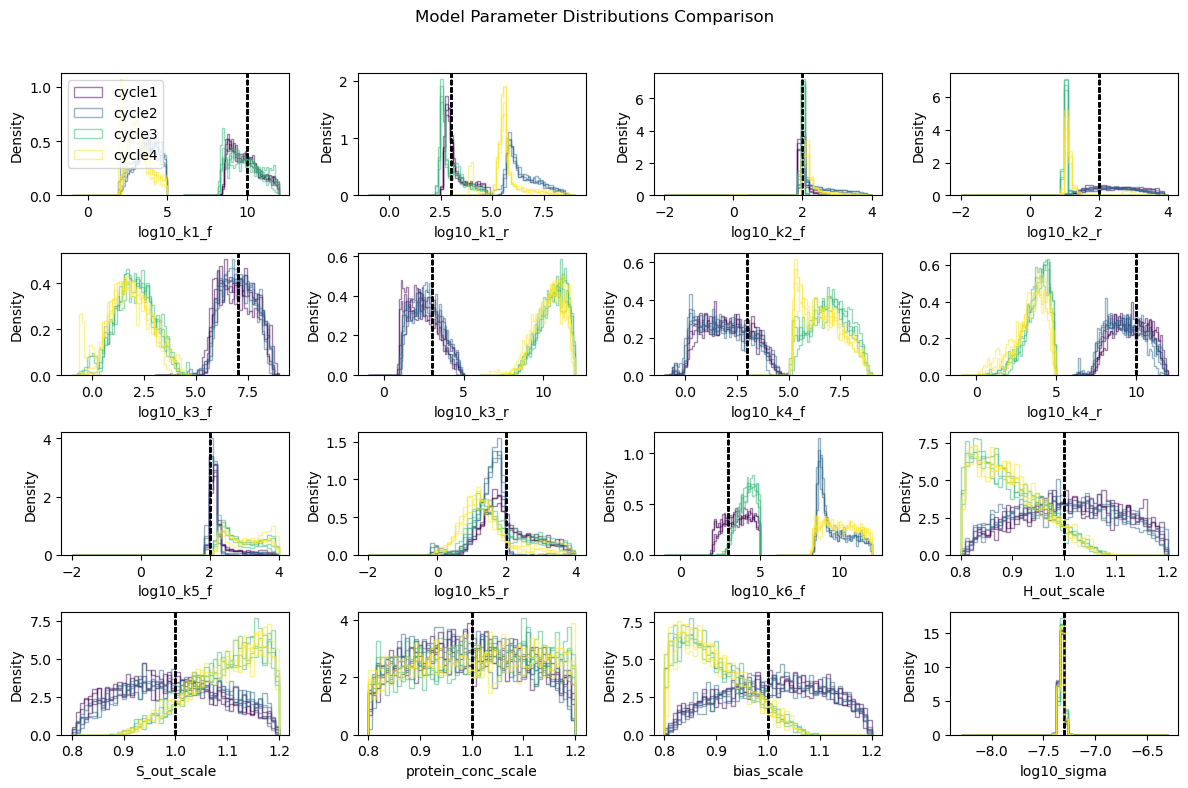

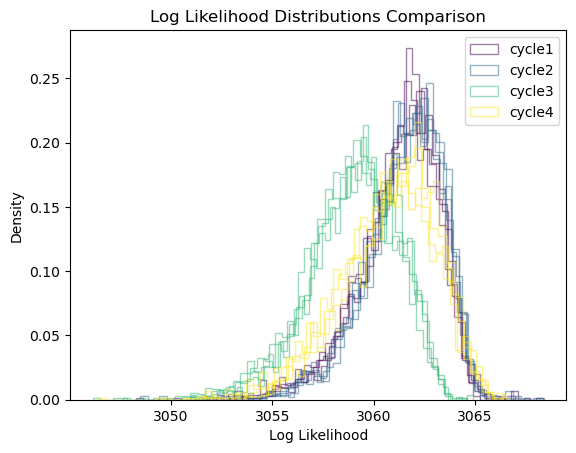

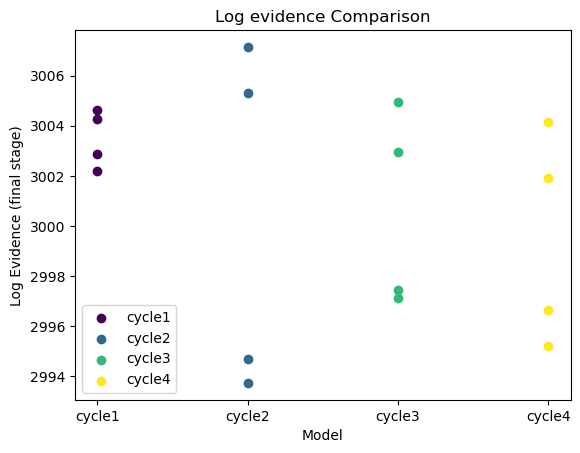

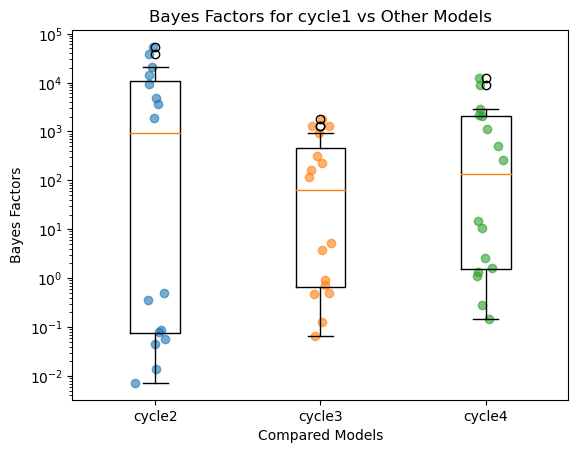

In [78]:
import numpy as np
import seaborn as sns

def plot_sampling_distributions_comparison(all_data, parameter_info, model_names, parameter_nominals):
    plt.style.use('default')
    num_bins = 50

    model_parameters = {model_name: all_data[model_name][0][0].shape[1] for model_name in model_names}
    max_num_parameters = max(model_parameters.values())

    num_cols = math.ceil(math.sqrt(max_num_parameters))
    num_rows = math.ceil(max_num_parameters / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 2 * num_rows))
    axs = axs.flatten()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        num_replicas = len(all_data[model_name])
        num_parameters = all_data[model_name][0][0].shape[1]

        parameter_names = parameter_info[model_name]['names']
        parameter_ranges = parameter_info[model_name]['ranges']
        #parameter_nominals = parameter_info[model_name]['nominals']

        for replica_idx, replica_data in enumerate(all_data[model_name]):
            samples = replica_data[0]

            for param_idx in range(num_parameters):
                if replica_idx == 0:
                    label = f"{model_name}"
                else:
                    label = None
                axs[param_idx].hist(samples[:, param_idx], bins=num_bins, alpha=0.5, density=True, histtype='step', color=colors[model_idx], label=label, range=parameter_ranges[param_idx])
                axs[param_idx].axvline(parameter_nominals[param_idx], linestyle='--', color='k', linewidth=1)
                axs[param_idx].set_xlabel(parameter_names[param_idx])
                axs[param_idx].set_ylabel('Density')

    axs[0].legend()
    fig.suptitle('Model Parameter Distributions Comparison')

    for param_idx in range(max_num_parameters, num_rows * num_cols):
        fig.delaxes(axs[param_idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig


def plot_likelihoods_comparison(all_data, model_names):
    fig, ax = plt.subplots()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        for replica_idx, replica_data in enumerate(all_data[model_name]):
            if replica_idx == 0:
                label = f"{model_name}"
            else:
                label = None
            ax.hist(replica_data[1], bins=num_bins, alpha=0.5, density=True, histtype='step', color=colors[model_idx], label=label)

    ax.set_xlabel('Log Likelihood')
    ax.set_ylabel('Density')
    ax.legend()
    plt.title('Log Likelihood Distributions Comparison')
    return fig


def plot_log_evidence_comparison(all_data, model_names):
    fig, ax = plt.subplots()

    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    for model_idx, model_name in enumerate(model_names):
        for replica_idx, replica_data in enumerate(all_data[model_name]):
            if replica_idx == 0:
                label = f"{model_name}"
            else:
                label = None
            ax.scatter(model_idx + 1, replica_data[2][-1], color=colors[model_idx], label=label)

    ax.set_xlabel('Model')
    ax.set_ylabel('Log Evidence (final stage)')
    ax.legend()
    plt.title('Log evidence Comparison')

    # Set the x-axis ticks and labels
    ax.set_xticks(range(1, len(model_names) + 1))
    ax.set_xticklabels(model_names)
    return fig

def calculate_bayes_factors(all_data, model_names, model_a):
    bayes_factors = {}

    for model_name in model_names:
        if model_name != model_a:
            bayes_factors[model_name] = []

    for replica_a_idx, replica_a_data in enumerate(all_data[model_a]):
        log_evidence_a = replica_a_data[2][-1]

        for model_name in model_names:
            if model_name != model_a:
                for replica_b_idx, replica_b_data in enumerate(all_data[model_name]):
                    log_evidence_b = replica_b_data[2][-1]
                    bayes_factor = np.exp(log_evidence_a - log_evidence_b)
                    bayes_factors[model_name].append(bayes_factor)
    return bayes_factors


def plot_bayes_factors(bayes_factors, model_a):
    fig, ax = plt.subplots()
    model_names = list(bayes_factors.keys())
    bayes_factors_values = [bayes_factors[model_name] for model_name in model_names]

    ax.boxplot(bayes_factors_values)
    ax.set_xticklabels(model_names)
    ax.set_xlabel('Compared Models')
    ax.set_ylabel('Bayes Factors')
    ax.set_title(f'Bayes Factors for {model_a} vs Other Models')
    ax.set_yscale("log") 

    # Overlay the scatter plot
    for model_idx, model_name in enumerate(model_names):
        y = bayes_factors[model_name]
        x = np.random.normal(model_idx + 1, 0.04, size=len(y))  # Add jitter along x-axis for better visibility
        ax.scatter(x, y, alpha=0.6)   
    
    return fig



# Call the comparison functions
ref_values = parameter_info['cycle1']['nominals']
fig = plot_sampling_distributions_comparison(all_data,parameter_info, model_names, ref_values)
save_figure(fig, f"model_comparison_sampling_distributions.png", output_directory);
fig = plot_likelihoods_comparison(all_data, model_names)
save_figure(fig, f"model_comparison_log_likelihood_distributions.png", output_directory);
fig = plot_log_evidence_comparison(all_data, model_names)
save_figure(fig, f"model_comparison_log_evidence_distributions.png", output_directory);

# bayes factor comparison
model_a = "cycle1"
bayes_factors = calculate_bayes_factors(all_data, model_names, model_a)
print(bayes_factors)

# Call the plot_bayes_factors function
fig = plot_bayes_factors(bayes_factors, model_a)
save_figure(fig, f"model_comparison_bayes_factors.png", output_directory);


k1_f = 
[9.99862129e+09 1.00028428e+10 1.00072528e+10 1.00113528e+10
 1.00150815e+10 1.00183770e+10 1.00212087e+10 1.00235814e+10
 1.00255276e+10 1.00270960e+10]
k1_f_0 = 
[1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]
k1_f_v = 
[0.99986213 1.00028428 1.00072528 1.00113528 1.00150815 1.0018377
 1.00212087 1.00235814 1.00255276 1.0027096 ]
I_tot_t = 
[9.61187307e-15 2.68361184e-08 2.50973046e-08 2.31089320e-08
 2.07217802e-08 1.80300064e-08 1.52739789e-08 1.26524136e-08
 1.02757128e-08 8.21496322e-09]


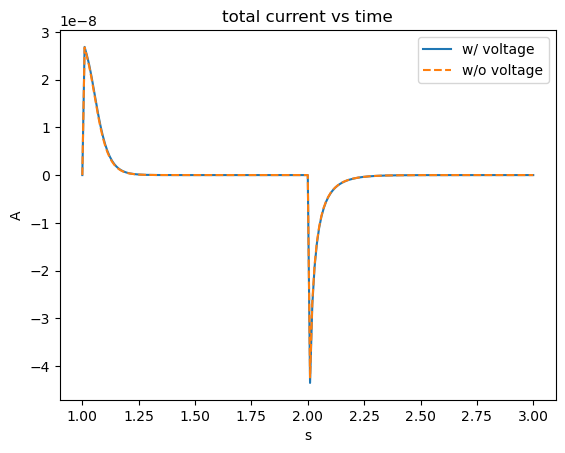

In [182]:
import tellurium as te
import matplotlib.pyplot as plt


def run_simulation(rr_model, selections):
    rr_model.resetToOrigin()
    rr_model.integrator.absolute_tolerance = 1e-15
    rr_model.integrator.relative_tolerance = 1e-12
    
    rr_model.conc_H_out = 1e-7
    rr_model.conc_S_out = 1e-3
    results_1 = rr_model.simulate(0,1,100, selections=selections)

    rr_model.conc_H_out = 5e-7
    rr_model.conc_S_out = 1e-3
    results_2 = rr_model.simulate(1,2,100, selections=selections)

    rr_model.conc_H_out = 1e-7
    rr_model.conc_S_out = 1e-3
    results_3 = rr_model.simulate(2,3,100, selections=selections)

    results = np.transpose(np.vstack([results_1, results_2, results_3]))
    return results

rr_model = te.loada("/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/antiporter_1_1_12D_cycle1/antiporter_1_1_12D_cycle1_antimony_voltage.txt")
selections = [ "time", "k1_f", "k1_f_0", "k1_f_v", "net_ion_influx", "I_t_per_liposome", "I_t_per_liposome_sum", "Q_t", "V", "I_t_total", "Q_t_total", "V_total"]
results = run_simulation(rr_model, selections)

plt.plot(results[0][100:], results[-3][100:], label='w/ voltage')

rr_model2 = te.loada("/Users/georgeau/Desktop/GitHub/Bayesian_Transporter/new/antiporter_1_1_12D_cycle1/antiporter_1_1_12D_cycle1_antimony.txt")
selections2 = [ "time", "k1_f", "net_ion_influx", "I_t_per_liposome", "I_t_total"]
results2 = run_simulation(rr_model2, selections2)

plt.plot(results2[0][100:], results2[-1][100:], label='w/o voltage', ls='--')
plt.legend()
plt.title("total current vs time")
plt.ylabel("A")
plt.xlabel("s")

np.array_equal(results[-3][100:],results2[-1][100:])

print(f"k1_f = \n{results[1][100:110]}")
print(f"k1_f_0 = \n{results[2][100:110]}")
print(f"k1_f_v = \n{results[3][100:110]}")
print(f"I_tot_t = \n{results[-3][100:110]}")
print(f"I_tot_t = \n{results2[-3][100:110]}")


F/RT = 39.58766463386939
eps_1_f*F/RT = 6.571552329222318


Text(0.5, 1.0, 'exp(-eps*v*F/RT)')

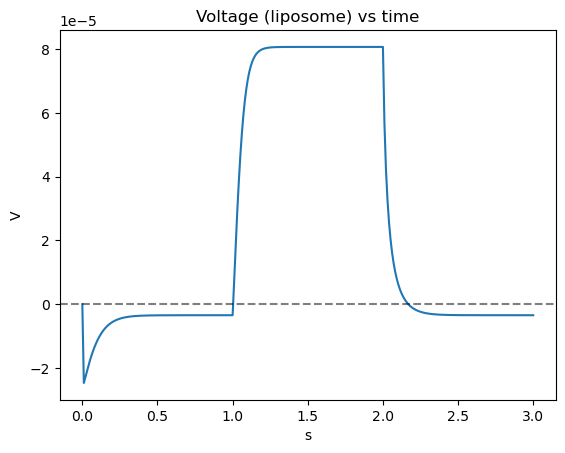

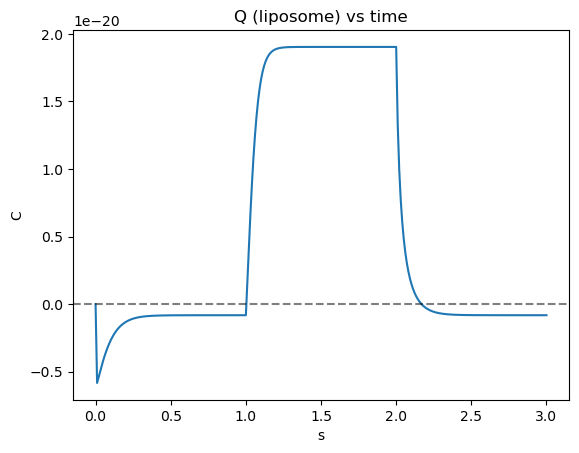

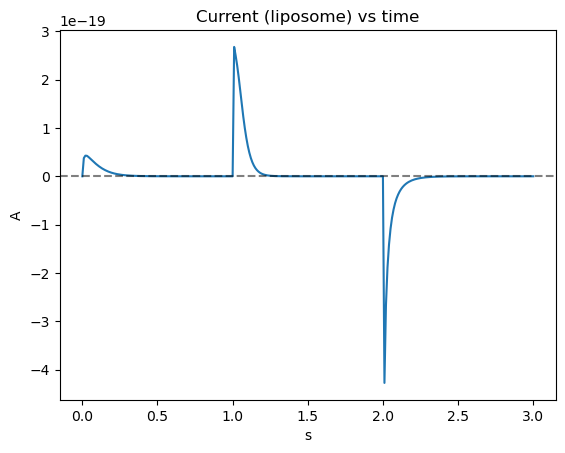

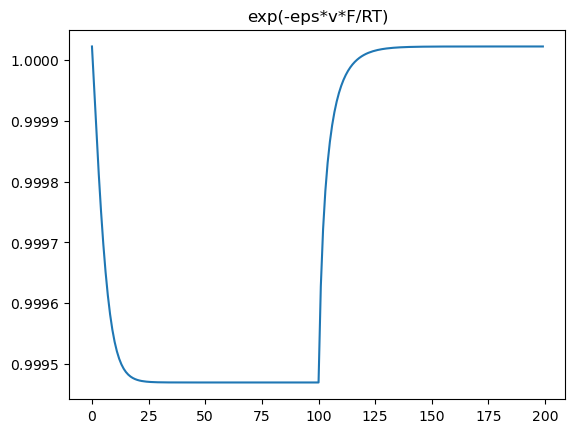

In [179]:
print(f"F/RT = {rr_model.F_over_RT}")
print(f"eps_1_f*F/RT = {rr_model.eps_1_f*rr_model.F_over_RT}")
# print(f"v = \n{results[-4][100:]}")
# print(f"eps*v*F/RT = \n{rr_model.eps_1_f*rr_model.F_over_RT*results[-4][100:]}")
# print(f"Q/C = \n{results[-5][100:]/rr_model.C_m}")

plt.figure()
plt.plot(results[0][:], results[-4][:])
plt.axhline(0, ls='--', color='black', alpha=0.5)
plt.title('Voltage (liposome) vs time')
plt.ylabel('V')
plt.xlabel('s')

plt.figure()
plt.plot(results[0][:], results[-5][:])
plt.axhline(0, ls='--', color='black', alpha=0.5)
plt.title('Q (liposome) vs time')
plt.ylabel('C')
plt.xlabel('s')

plt.figure()
plt.plot(results[0][:], results[-7][:])
plt.axhline(0, ls='--', color='black', alpha=0.5)
plt.title('Current (liposome) vs time')
plt.ylabel('A')
plt.xlabel('s')


import matplotlib.ticker as ticker
fig, ax = plt.subplots()
# Customize the y-axis tick label format
formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-3, 3))
ax.yaxis.set_major_formatter(formatter)
ax.plot(np.exp(-1*rr_model.eps_1_f*rr_model.F_over_RT*results[-4][100:]))
ax.set_title('exp(-eps*v*F/RT)')

In [149]:
print(rr_model.liposome_surface_area)
print(rr_model.C_m)

3.1415899999999994e-14
2.3561924999999996e-16
